# Part 2 - Vector Data

In this, second, notebook we will focus on vector data.

In [1]:
# ONLY NEEDS TO BE RUN IF USING GOOGLE COLAB
%%capture
!pip install cartopy s3fs mapclassify

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy as cp
import xarray as xr
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import folium
import s3fs

## Shapefiles

Shapefiles are files that contain vectors (shapes) geo-referenced to a particular coordinate system. They are often used in hydrology to define catchment areas, river channels and hydrological administrative regions.

Each 'shape' in a shapefile will typically have a set of attributes that tell you more information about the shape, such as the name of the river or catchment it defines.

The easiest way to see what's in a shapefile in python is to use a package called [Geopandas](https://geopandas.org/en/stable/). It is essentially an extension of the [Pandas](https://pandas.pydata.org/) package, which is used to work with tabular data, and that we saw in Part 1.

**Sidenote:** Shapefiles often confusingly come with several ancillary files. The main shapefile will have a **'.shp'** ending, with ancillaries ending with some or all of **'shx', '.sbx', '.sbn', '.dbf', '.cpg', '.prj'**, which provide additional information about the vectors/shapes contained in the **'.shp'** file. Most shapefile packages in python and elsewhere will read in the information they need from these ancillary files automatically if you provide the path to the **'.shp'** file, and therefore most of the time you can ignore them! If reading the shapefiles from an S3 object storage filesystem, like we are doing below, the ancillary files need to be zipped up together with the **'.shp'** file and the zip archive read in for the ancillaries to be automatically loaded.

In [3]:
# Set up the S3 (object storage) filesystem object
s3 = s3fs.S3FileSystem(anon=True, endpoint_url="https://fdri-o.s3-ext.jc.rl.ac.uk")

In [4]:
# Read from the filesystem - note the zip as explained above
shapefile = gpd.read_file(s3.open('s3://example-data/gb_catchments.zip'))

In [5]:
shapefile

,OBJECTID,ID_STRING,ID,SHAPE_AREA,SHAPE_LEN,geometry
0,227,18010,18010.0,0.0,0.0,"POLYGON ((271449.998 695224.998, 271400 695224..."
1,244,21014,21014.0,0.0,0.0,"POLYGON ((310900.002 628474.999, 311150.002 62..."
2,245,21015,21015.0,0.0,0.0,"POLYGON ((356475.002 638850.002, 356349.999 63..."
3,247,21017,21017.0,0.0,0.0,"POLYGON ((323424.998 613149.998, 323375 613100..."
4,269,22004,22004.0,0.0,0.0,"POLYGON ((421150.002 612925, 421225.001 612850..."
...,...,...,...,...,...,...
1888,174,21003,21003.0,0.0,0.0,"POLYGON ((325775.002 640050, 325775.002 640000..."
1889,187,19021,19021.0,0.0,0.0,"POLYGON ((333800.001 667825.002, 333900.002 66..."
1890,197,20806,20806.0,0.0,0.0,"POLYGON ((363849.998 677374.998, 364024.998 67..."
1891,204,17004,17004.0,0.0,0.0,"POLYGON ((333000 699774.998, 333100.001 699774..."


The tabular representation of the shapefile shows each shape in the shapefile as a separate row. Each column shows an attribute of the shapes, with the actual vector geometry stored in the final column.

The attributes aren't particularly helpful. All we've got to go is some numeric identifiers.

Sometimes the 'attrs' command below can produce some more information:

In [6]:
shapefile.attrs

{}

But not this time. If this shapefile was following [FAIR](https://www.go-fair.org/fair-principles/)\* guidelines it should have some more useful metadata!

\*Findable, Accessible, Interoperable, Reproducable

Fortunately for us, I know what this dataset is, and it's a collection of all the catchments in the UK.

We can see this if we plot the entire file, i.e. all the catchments it contains:

<Axes: >

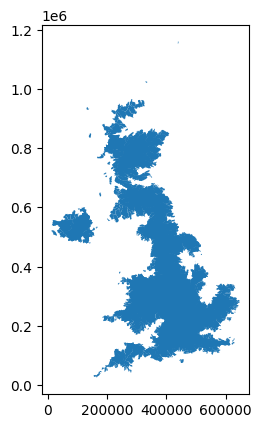

In [7]:
shapefile.plot()

We can now see that it looks like a map of the UK, but the overlapping nature of the catchments makes it hard to make out much detail. We can try to see more detail by removing the facecolor in the plot.

<Axes: >

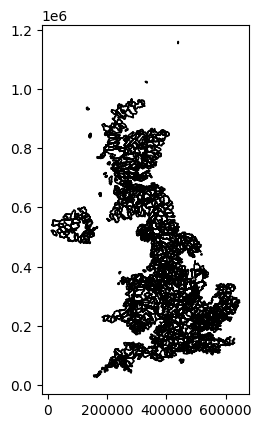

In [8]:
shapefile.plot(facecolor='None')

We've now made the shapes transparent and just drawn their borders instead, but it's still hard to make out any detail because there are too many overlapping catchments. Let's focus on an individual catchment instead.

The [Thames](https://nrfa.ceh.ac.uk/data/station/spatial/39001) has catchment ID 39001. Given the catchment ID is one of the attributes listed in the table (given as "ID_STRING"), we can use it to select this specific catchment from the table. Cathment ID can also be numerically selected using the "ID" attribute, we'll look at that later.

In [9]:
thames = shapefile.loc[shapefile['ID_STRING'] == '39001']

thames

,OBJECTID,ID_STRING,ID,SHAPE_AREA,SHAPE_LEN,geometry
73,826,39001,39001.0,0.0,0.0,"POLYGON ((517750.002 169874.998, 517800 169874..."


Let's plot it to see what the shape of the Thames catchment looks like:

<Axes: >

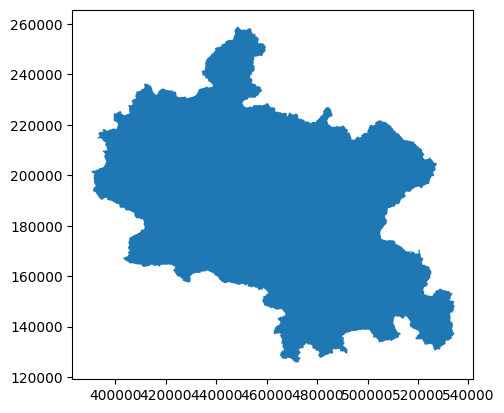

In [10]:
thames.plot()

All the sub-catchments of the Thames basin will begin with '39', followed by a three-digit 0-padded number. This is where we can make use of the numerical "ID" attribute. Let's select all the Thames sub-catchments:

In [11]:
all_thames = shapefile.loc[lambda ds: ds['ID'] > 39000].loc[lambda ds: ds['ID'] < 40000]
all_thames

,OBJECTID,ID_STRING,ID,SHAPE_AREA,SHAPE_LEN,geometry
73,826,39001,39001.0,0.0,0.0,"POLYGON ((517750.002 169874.998, 517800 169874..."
74,833,39008,39008.0,0.0,0.0,"POLYGON ((444475 208750, 444425.002 208700.002..."
75,851,39026,39026.0,0.0,0.0,"POLYGON ((445849.998 241125, 445800.001 241125..."
76,861,39036,39036.0,0.0,0.0,"POLYGON ((504500 146774.999, 504525.001 146800..."
77,878,39058,39058.0,0.0,0.0,"POLYGON ((537150.001 172525, 537425.001 172249..."
...,...,...,...,...,...,...
1748,1018,39146,39146.0,0.0,0.0,"POLYGON ((453150.001 186424.999, 453199.998 18..."
1749,1019,39147,39147.0,0.0,0.0,"POLYGON ((486874.998 208350.002, 486950.002 20..."
1750,1020,39813,39813.0,0.0,0.0,"POLYGON ((524450 136374.999, 524475.001 136349..."
1751,1023,39825,39825.0,0.0,0.0,"POLYGON ((540575.001 167900.001, 540699.998 16..."


We need to set facecolor to 'None' again so that the shapes are not filled with colour. This allows us to see all the catchments in the Thames basin:

<Axes: >

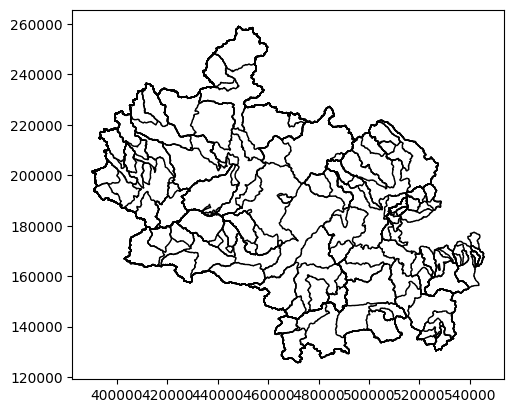

In [12]:
all_thames.plot(facecolor='None')

Now we're starting to get a better picture of what the Thames basin looks like!

Notice that for some reason the attribute 'SHAPE_AREA' in the shapefile is 0.0 for all catchments. That's annoying, as this is a genuinely useful catchment property we might want to use.

Fortunately, Geopandas is able to calculate the area for us, based on the geometeries in the 'geometry' column.

Let's assign these area values to a new column:

In [13]:
shapefile['catchment_areas'] = shapefile.area

shapefile

,OBJECTID,ID_STRING,ID,SHAPE_AREA,SHAPE_LEN,geometry,catchment_areas
0,227,18010,18010.0,0.0,0.0,"POLYGON ((271449.998 695224.998, 271400 695224...",3.913012e+08
1,244,21014,21014.0,0.0,0.0,"POLYGON ((310900.002 628474.999, 311150.002 62...",1.387013e+08
2,245,21015,21015.0,0.0,0.0,"POLYGON ((356475.002 638850.002, 356349.999 63...",2.390687e+08
3,247,21017,21017.0,0.0,0.0,"POLYGON ((323424.998 613149.998, 323375 613100...",3.859125e+07
4,269,22004,22004.0,0.0,0.0,"POLYGON ((421150.002 612925, 421225.001 612850...",2.029238e+08
...,...,...,...,...,...,...,...
1888,174,21003,21003.0,0.0,0.0,"POLYGON ((325775.002 640050, 325775.002 640000...",6.980112e+08
1889,187,19021,19021.0,0.0,0.0,"POLYGON ((333800.001 667825.002, 333900.002 66...",1.559963e+08
1890,197,20806,20806.0,0.0,0.0,"POLYGON ((363849.998 677374.998, 364024.998 67...",6.783751e+06
1891,204,17004,17004.0,0.0,0.0,"POLYGON ((333000 699774.998, 333100.001 699774...",1.593312e+08


Now that we have this information, let's do something with it.

Perhaps we're interested in finding the largest and smallest catchments within the Thames basin

In [14]:
all_thames = shapefile.loc[lambda df: df['ID'] > 39000].loc[lambda df: df['ID'] < 40000]
all_thames_sorted = all_thames.sort_values('catchment_areas')

In [15]:
all_thames_sorted

,OBJECTID,ID_STRING,ID,SHAPE_AREA,SHAPE_LEN,geometry,catchment_areas
1300,1027,39832,39832.0,0.0,0.0,"POLYGON ((527900.002 164775.002, 527924.998 16...",8.962501e+05
1741,950,39133,39133.0,0.0,0.0,"POLYGON ((527900.002 164775.002, 527924.998 16...",8.962501e+05
1283,932,39113,39113.0,0.0,0.0,"POLYGON ((438249.999 186175, 438499.999 186175...",1.381252e+06
1503,882,39062,39062.0,0.0,0.0,"POLYGON ((439649.999 186475.002, 439799.998 18...",1.686254e+06
1748,1018,39146,39146.0,0.0,0.0,"POLYGON ((453150.001 186424.999, 453199.998 18...",2.008751e+06
...,...,...,...,...,...,...,...
555,834,39009,39009.0,0.0,0.0,"POLYGON ((490975.002 179700, 490975.002 179650...",6.914146e+09
79,892,39072,39072.0,0.0,0.0,"POLYGON ((498025 177250, 497950.001 177175.001...",7.124934e+09
1738,930,39111,39111.0,0.0,0.0,"POLYGON ((503475.001 171349.998, 503349.999 17...",8.186454e+09
1284,939,39121,39121.0,0.0,0.0,"POLYGON ((509850.001 166974.998, 509950.001 16...",9.291766e+09


Looks like the smallest is at the top, largest is at the bottom.

In [16]:
smallest_thames = all_thames_sorted.iloc[[0],:]

**Sidenote:** the extra '[]' around the 0 above and below, which isn't usually necessary. Here they are needed to ensure that the output of the command remains a 'Table' rather than a 'Series'. Geopandas only knows about Tables, not Series, so to retain the geographical capabilities of Geopandas, we need to retain the table!

**Note:** We want the second largest in this table, as the largest is the whole Thames basin itself, and we want the largest *within* this

In [17]:
largest_thames = all_thames_sorted.iloc[[-2],:]

Now let's see them on the map:

<Axes: >

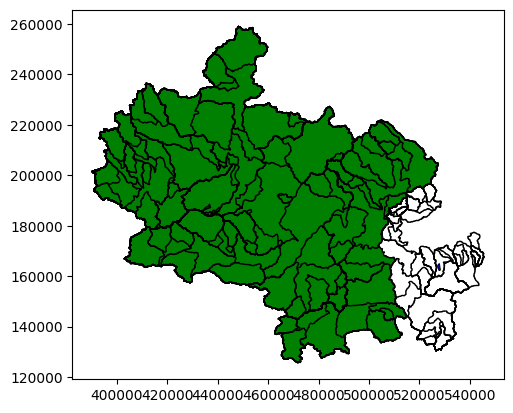

In [18]:
all_thames_sorted.plot(facecolor='None')
current_axes = plt.gca() # we want all of these commands to plot on the same set of axes, this retrieves a 'handle' to the axes
largest_thames.plot(facecolor='green', ax=current_axes, zorder=0) # note we specify the axes
smallest_thames.plot(facecolor='blue', ax=current_axes)

Can you spot the blue catchment? What do you think the 'zorder' parameter is doing?

Now let's spruce up our plots a bit. We can use the [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) package to produce good plots.

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


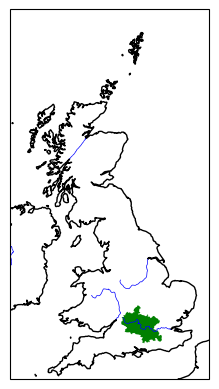

In [19]:
gbax = plt.axes(projection=cp.crs.OSGB())
gbax.set_global()
gbax.coastlines(resolution='10m')
thames.plot(ax=gbax, facecolor='green')
rivers = cp.feature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m', edgecolor='blue', facecolor='none', lw=0.5)
gbax.add_feature(rivers)

Now we can see where the Thames catchment sits in the UK!

Let's go through the code that gave us the plot:

```gbax = plt.axes(projection=cp.crs.OSGB())```

Here we are creating a set of axes that we'll be using for the plot. The ```projection``` argument defines what map projection to use for the plotting. In this case we are using the Ordnance Survey's grid, which approximates the UK as a flat plane with x/y coordinates.

**Note:** The OSGB projection matches the coordinate system that the shapefile is defined on. In the UK this is typical for hydrological data. Datasets covering other geographical areas are more likely to be a lonlat grid, or sometimes a UTM cartesian grid (which the OSGB grid is an example of). For lonlat grids a good default for the projection argument would be ```projection=cp.crs.PlateCarree()```. Sometimes you can find out which coordinate system the shapefile is using from the crs attribute, e.g.: ```shapefile.crs```.

```gbax.set_global()```

This forces the axes to their maximum possible extent for the given projection. What happens if we remove this?

```gbax.coastlines(resolution='10m')```

This adds coastlines to the axes with 10m resolution.

```thames.plot(ax=gbax, facecolor='green')```

This is the same plotting function we've been using throughout, with the addition of specifying the axes on which we wish to plot, and the colour of the shape(s) we are plotting.

```rivers = cp.feature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m', edgecolor='blue', facecolor='none', lw=0.5)```

This one looks complicated but really it's just accessing a built-in shapefile that cartopy has access to. ```physical``` is the category, ```rivers_lake_centerlines``` is the name of the dataset, ```10m``` is the resolution we want to use, then ```edgecolour``` and ```facecolor``` are the same as in the plotting command and ```lw=0.5``` sets the line-width of the plotted shapes.

**Further info:** Cartopy is actually accessing the shapefile datasets from the [Natural Earth website](https://www.naturalearthdata.com/downloads/). See what other datasets you can make use of for free!

**Further info:** There is also a UK Rivers shapefile available on the object store at 's3://example-data/main_uk_river_1km.zip', see if you can plot it instead of the cartopy built-in.

## Further Resources

- [Geopandas documentation](https://geopandas.org/en/stable/)
- [Wikipedia over-detailed description of Shapefiles](https://en.wikipedia.org/wiki/Shapefile)
- [geoJSON](https://geojson.org/)
- [EPSG Codes](https://epsg.org/home.html)
- [Cartopy projections](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html)
- [Python Data Visualisation](https://courses.spatialthoughts.com/python-dataviz.html)

# Supplementary Info

We can go one step further and easily plot the shapefile data on a zoomable interactive map:

In [20]:
thames.crs = 27700

m = thames.explore(style_kwds={'color': 'black', 'fill': False})

In [21]:
m

To plot multiple shapefiles on one map, we have to first set up the base map manually. The ```explore()``` function uses a package called [folium](https://python-visualization.github.io/folium/latest/) under the hood, so we use this to set up our base map. To get the map to open with a specific location centred and at a specific zoom level, the ```location``` and ```zoom_start``` parameters can be specified. The ```location``` parameter is specified as [lat,lon] and picking the right zoom level is trial and error, but as a rough guide it starts at 1 (most zoomed out).

In [22]:
rivers_shapefile = gpd.read_file(s3.open('s3://example-data/main_uk_river_1km.zip')) # reading in rivers shapefile from object store

mapplot = folium.Map(location=[51.5, -1], zoom_start=8)
thames.explore(m=mapplot, style_kwds={'color': 'black', 'fill': False})
rivers_shapefile.crs = 27700
rivers_shapefile.explore(m=mapplot, style_kwds={'fill': False, 'color': 'blue', 'opacity': 0.5})

The ```explore()``` function is very customisable, see below for all the options. Have a play around and see what more you can do!

**Note:** The 'crs' (coordinate reference system) needs to be set in order to be plotted with the ```explore()``` function. This specifies the coordinate system the shapefile is using, so that the ```explore()``` function knows how to interpret the coordinates of the shapes in the shapefile and where to put them on a map.

In [23]:
thames.explore?

One cool thing you can do, to finish this section, is save this map to a html file which you can then open with any internet browser:

In [24]:
mapplot.save('thames_cat_map.html')

## Other vector data formats

You may come across [geojson](https://geojson.org/) files as a popular alternative to shapefiles. Geopandas can work with these too, and the functionality is exactly the same as if you were working with shapefiles. For example:

In [25]:
scotland = gpd.read_file(s3.open("s3://example-data/scotland_boundaries.geojson"))

<Axes: >

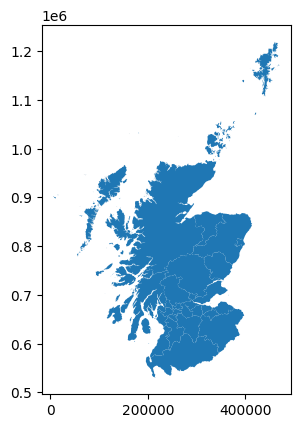

In [26]:
scotland.plot()

Sometimes you may find geographical information has been stored in text-based csv files. Once again Geopandas can work with these in the same way as the other formats mentioned, though reading them in involves slightly different commands:

In [27]:
buoys = pd.read_csv(s3.open("s3://example-data/buoy_data.csv"))

In [28]:
buoys

,buoy_id,Name,Manufacturer,Depth,Type,operator,Country,Site Type,latitude,longitude
0,1,Beryl A,saab,104m,Downward-looking wave radar,Shell UK,Scotland,Ocean,59.500000,1.500000
1,2,Cardigan Bay,Waverider,48m,Directional,Met Office,Wales,Coastal,52.433333,-4.800000
2,3,Chesil Waverider,Waverider,10m,Directional,Channel Coastal Observatory,England,Coastal,50.600000,-2.520000
3,4,Claymore,saab,150m,Downward-looking wave radar,Oil and Gas UK,Scotland,Ocean,58.400000,-0.300000
4,5,Firth of Forth WaveNet Site,Waverider MkIII,65m,Directional,Cefas,Scotland,Coastal,56.190000,-2.500000
5,6,Greenwich Light Vessel,unknown,51m,Unspecified wave measurement sensor,Met Office,England,Coastal,50.733167,-0.959333
6,7,Hayling Island Waverider,Triaxiy,10.2m,Directional,Cefas,England,Coastal,50.730000,-0.960000
7,8,K7,Triaxiys,650m,Directional,Cefas,Scotland,Ocean,60.483330,-4.166667
8,9,Lomond,saab,NaN,Downward-looking wave radar,Oil and Gas UK,Scotland,Ocean,57.200000,2.200000
9,11,South Pembrokeshire WaveNet Site,Waverider MkIII,20m,Directional,Cefas,Wales,Coastal,51.456167,-5.230333


Note that we have used *Pandas* instead of *Geo*pandas to read in this file as it is a text file, not a file containing vectors. The location information in this csv file is stored in the latitude and longitude columns. *Geo*pandas can be told to make these into vector points:

In [29]:
buoys_geo = gpd.GeoDataFrame(buoys, geometry=gpd.points_from_xy(buoys.longitude, buoys.latitude),
                             crs="EPSG:4326")

**Note:** we use the [4326 EPSG code](https://epsg.io/4326) for the coordinate reference system, as this is the standard one for longitude and latitude coordinate systems.

In [30]:
buoys_geo

,buoy_id,Name,Manufacturer,Depth,Type,operator,Country,Site Type,latitude,longitude,geometry
0,1,Beryl A,saab,104m,Downward-looking wave radar,Shell UK,Scotland,Ocean,59.500000,1.500000,POINT (1.5 59.5)
1,2,Cardigan Bay,Waverider,48m,Directional,Met Office,Wales,Coastal,52.433333,-4.800000,POINT (-4.8 52.43333)
2,3,Chesil Waverider,Waverider,10m,Directional,Channel Coastal Observatory,England,Coastal,50.600000,-2.520000,POINT (-2.52 50.6)
3,4,Claymore,saab,150m,Downward-looking wave radar,Oil and Gas UK,Scotland,Ocean,58.400000,-0.300000,POINT (-0.3 58.4)
4,5,Firth of Forth WaveNet Site,Waverider MkIII,65m,Directional,Cefas,Scotland,Coastal,56.190000,-2.500000,POINT (-2.5 56.19)
5,6,Greenwich Light Vessel,unknown,51m,Unspecified wave measurement sensor,Met Office,England,Coastal,50.733167,-0.959333,POINT (-0.95933 50.73317)
6,7,Hayling Island Waverider,Triaxiy,10.2m,Directional,Cefas,England,Coastal,50.730000,-0.960000,POINT (-0.96 50.73)
7,8,K7,Triaxiys,650m,Directional,Cefas,Scotland,Ocean,60.483330,-4.166667,POINT (-4.16667 60.48333)
8,9,Lomond,saab,NaN,Downward-looking wave radar,Oil and Gas UK,Scotland,Ocean,57.200000,2.200000,POINT (2.2 57.2)
9,11,South Pembrokeshire WaveNet Site,Waverider MkIII,20m,Directional,Cefas,Wales,Coastal,51.456167,-5.230333,POINT (-5.23033 51.45617)


<GeoAxes: >

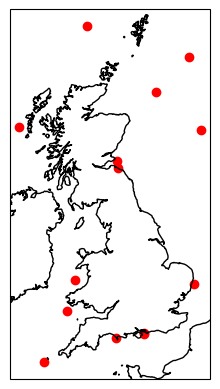

In [31]:
gbax = plt.axes(projection=cp.crs.PlateCarree())
gbax.coastlines(resolution='10m')
buoys_geo.plot(ax=gbax, color='red')

**Note:** we are using the [PlateCarree projection](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html#platecarree), which is a standard one to use for plotting data in lon/lat coordinates.